## MISC

In [ ]:
import rasterio
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
img = cv2.imread('Data/Tiles_Tif/output_0_7168.tif', cv2.IMREAD_ANYDEPTH)

In [ ]:
plt.imshow(img)

In [ ]:
int_img = img.astype(np.uint8)
plt.imshow(int_img)

In [ ]:
lineLength = 1
lineGap = 50

In [ ]:
lines = cv2.HoughLinesP(int_img, 1, np.pi/180, threshold=150, minLineLength=lineLength, maxLineGap=lineGap)

In [ ]:
lines = lines.reshape(-1, 4)
lines

In [ ]:
def plot_line_segments(line_segments):
  """Plots a list of line segments with the origin at the top-left corner.

  Args:
    line_segments: A list of tuples, where each tuple represents (x1, y1, x2, y2) coordinates of a line segment.
  """

  for x1, y1, x2, y2 in line_segments:
    plt.plot([x1, x2], [y1, y2], color='blue')

  plt.xlim(0, 512)
  plt.ylim(0, 512)
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.title('Line Segments')
  plt.grid(True)
  plt.gca().invert_yaxis()
  plt.show()


In [ ]:
plot_line_segments(lines)

In [ ]:
from sklearn.cluster import KMeans

def cluster_lines(lines):
  """Clusters lines based on slope and intercept.

  Args:
    lines: A list of lines represented as (x1, y1, x2, y2) tuples.

  Returns:
    A list of representative lines.
  """

  features = []
  for x1, y1, x2, y2 in lines:
    # Handle vertical lines
    if x2 - x1 == 0:
      slope = float('inf')
      intercept = x1
    else:
      slope = (y2 - y1) / (x2 - x1)
      intercept = y1 - slope * x1
    features.append([slope, intercept])

  # Handle infinite slopes (vertical lines)
  features = np.array(features)
  features[np.isinf(features)] = np.nan

  # Clustering (adjust n_clusters as needed)
  kmeans = KMeans(n_clusters=5, random_state=0).fit(features)

  # Represent each cluster by its centroid
  cluster_centers = kmeans.cluster_centers_

  # Convert cluster centers back to line format
  representative_lines = []
  for slope, intercept in cluster_centers:
    # Handle infinite slopes
    if np.isnan(slope):
      x1 = intercept
      y1 = 0
      x2 = intercept
      y2 = 100  # Adjust y2 as needed
    else:
      x1 = 0
      y1 = intercept
      x2 = 100
      y2 = slope * 100 + intercept
    representative_lines.append((x1, y1, x2, y2))

  return representative_lines

In [ ]:
rep_lines = cluster_lines(lines)

In [ ]:
rep_lines

In [ ]:
class Line(object):
    def __init__(self, coordinates=[0, 0, 1, 1]):
        """
        coordinates: [y0, x0, y1, x1]
        """
        assert isinstance(coordinates, list)
        assert len(coordinates) == 4
        assert coordinates[0]!=coordinates[2] or coordinates[1]!=coordinates[3]
        self.__coordinates = coordinates

    @property
    def coord(self):
        return self.__coordinates

    @property
    def length(self):
        start = np.array(self.coord[:2])
        end = np.array(self.coord[2::])
        return np.sqrt(((start - end) ** 2).sum())

    def angle(self):
        y0, x0, y1, x1 = self.coord
        if x0 == x1:
            return -np.pi / 2
        return np.arctan((y0-y1) / (x0-x1))

    def rescale(self, rh, rw):
        coor = np.array(self.__coordinates)
        r = np.array([rh, rw, rh, rw])
        self.__coordinates = np.round(coor * r).astype(np.int).tolist()

    def __repr__(self):
        return str(self.coord)

In [ ]:
def sa_metric(angle_p, angle_g):
    d_angle = np.abs(angle_p - angle_g)
    d_angle = min(d_angle, np.pi - d_angle)
    d_angle = d_angle * 2 / np.pi
    return max(0, (1 - d_angle)) ** 2

def se_metric(coord_p, coord_g, size=(512, 512)):
    c_p = [(coord_p[0] + coord_p[2]) / 2, (coord_p[1] + coord_p[3]) / 2]
    c_g = [(coord_g[0] + coord_g[2]) / 2, (coord_g[1] + coord_g[3]) / 2]
    d_coord = np.abs(c_p[0] - c_g[0])**2 + np.abs(c_p[1] - c_g[1])**2
    d_coord = np.sqrt(d_coord) / max(size[0], size[1])
    return max(0, (1 - d_coord)) ** 2

def len_metric(pred_len, ground_len):
    if pred_len == 0 or ground_len == 0:
        return 0  # Handle division by zero
    
    relative_difference = abs(pred_len - ground_len) / max(pred_len, ground_len)
    similarity_score = 1 - relative_difference
    return similarity_score
    
def EA_metric(l_pred, l_gt, size=(512, 512)):
    se = se_metric(l_pred.coord, l_gt.coord, size=size)
    sa = sa_metric(l_pred.angle(), l_gt.angle())
    ld = len_metric(l_pred.length, l_gt.length)
    return sa * se * ld

In [ ]:
l1 = Line([17, 511, 218, 376])
l2 = Line([14, 511, 218, 378])
print(EA_metric(l1, l2))

In [ ]:
lines[0]

In [ ]:
lines = lines.reshape(-1, 4)

In [ ]:
coord_file = "Data/Tile_Line_Coo/output_0_7168_coo.txt"

read_coordinates = []
with open(coord_file, 'r') as f:
    for line in f:
      values = line.strip().split(',')
      if values:  # Check if the line is not empty
        try:
          read_coordinates.append(list(float(value) for value in values))
        except ValueError:
          print(f"Error parsing line: {line}")

In [ ]:
read_coordinates[0]

In [ ]:
def calculate_metrics(ground_truth, predicted_truth):
  """Calculates metrics for corresponding elements in ground truth and predicted truth.

  Args:
    ground_truth: A list of ground truth line segments.
    predicted_truth: A list of predicted line segments.

  Returns:
    A list of calculated metrics.
  """

  num_gt = len(ground_truth)
  num_pred = len(predicted_truth)
  metrics = np.zeros((num_gt, num_pred))

  for i in range(num_gt):
    for j in range(num_pred):
      gt_coord = ground_truth[i]
      pred_coord = predicted_truth[j]
      l1 = Line(gt_coord)
      l2 = Line(pred_coord)
      metric = EA_metric(l1, l2)
      if metric > 0.95:
          print(metric)        

In [ ]:
rep_lines = rep_lines.tolist()

In [ ]:
calculate_metrics(rep_lines, read_coordinates)

## Post-Processing

### Merging Tiles

In [1]:
import rasterio
from rasterio.merge import merge
import os
import glob

In [2]:
curr_path = os.getcwd()

print(curr_path)

D:\Masters\OVGU\VII_Semester\Thesis\jupyter_notebooks


In [5]:
tiles_dir = os.path.join(curr_path, 'Data\outputs_tile_2')

print(tiles_dir)

D:\Masters\OVGU\VII_Semester\Thesis\jupyter_notebooks\Data\outputs_tile_2


In [6]:
# Search pattern to find all .tif files
search_criteria = "*.tif"
q = os.path.join(tiles_dir, search_criteria)
tile_files = glob.glob(q)

In [7]:
# Open all the files and append to a list
src_files_to_mosaic = []
for fp in tile_files:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)

In [9]:
# Merge the individual tiles
mosaic, out_trans = merge(src_files_to_mosaic)

In [10]:
# Update metadata
out_meta = src.meta.copy()

In [11]:
# Update to new dimensions, transform, and CRS
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans,
    "crs": src.crs
})

In [12]:
# Write the merged file to disk
output_fp = os.path.join(curr_path, "Data/Merged/merged.tif")
with rasterio.open(output_fp, "w", **out_meta) as dest:
    dest.write(mosaic)

### Hough Begins

In [67]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import skeletonize
from skimage.transform import probabilistic_hough_line
import rasterio
from skimage.draw import line as skimage_line

In [4]:
curr_path = os.getcwd()

print(curr_path)

D:\Masters\OVGU\VII_Semester\Thesis\jupyter_notebooks


In [5]:
tif_path = os.path.join(curr_path, 'Data\Merged\merged.tif')

print(tif_path)

D:\Masters\OVGU\VII_Semester\Thesis\jupyter_notebooks\Data\Merged\merged.tif


In [6]:
image = cv2.imread(tif_path, cv2.IMREAD_GRAYSCALE)

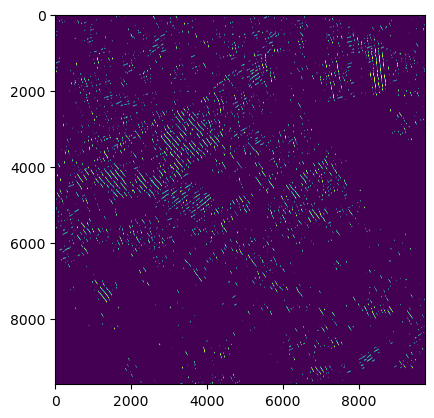

In [7]:
plt.imshow(image)

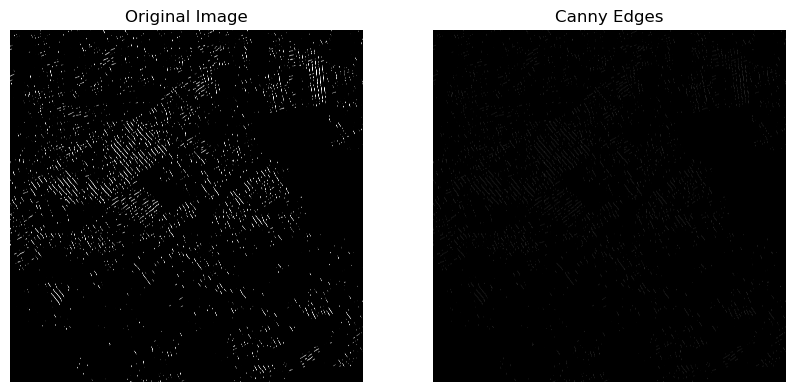

In [8]:
edges = cv2.Canny(image, threshold1=100, threshold2=200)

plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Edge-detected Image
plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edges')
plt.axis('off')

plt.show()

In [11]:
print(len(edges))

9728


In [17]:
# Find contours in the edge-detected image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours onto a new image
lines = np.zeros_like(image)
contour_image = cv2.drawContours(lines, contours, -1, (255, 255, 255), thickness=5)

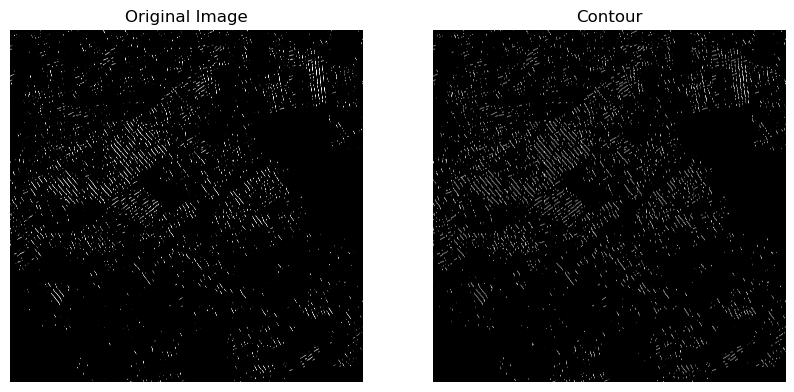

In [18]:
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Edge-detected Image
plt.subplot(1, 2, 2)
plt.imshow(lines, cmap='gray')
plt.title('Contour')
plt.axis('off')

plt.show()

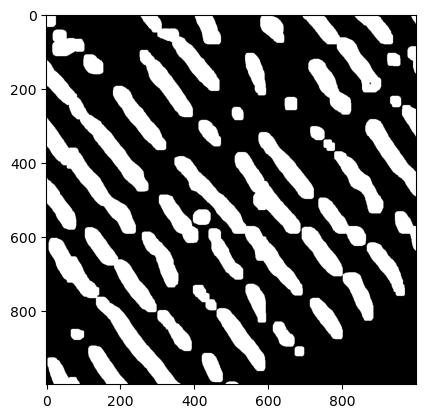

In [47]:
# Choose a region to zoom into
x_start, x_end = 3000, 4000
y_start, y_end = 3000, 4000

zoomed_dilated_image = dilated_edges[y_start:y_end, x_start:x_end]

# Display the zoomed-in section
plt.imshow(zoomed_contour_image, cmap='gray')
plt.show()

In [35]:
# Define a kernel
kernel = np.ones((15,15), np.uint8)

# Apply dilation
dilated_edges = cv2.dilate(contour_image, kernel, iterations=1)

binary_image = dilated_edges > 0

skeleton = skeletonize(binary_image)

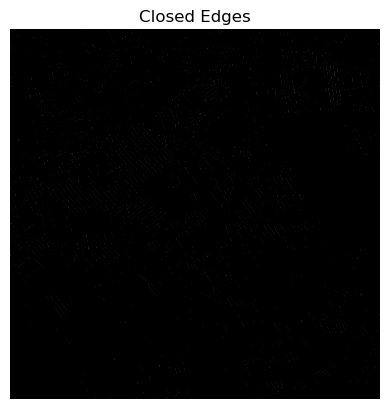

In [37]:
skeleton_uint8 = (skeleton * 255).astype(np.uint8)

plt.imshow(skeleton_uint8, cmap='gray')  # Display in grayscale
plt.title('Closed Edges')  # Optional: Title for the plot
plt.axis('off')  # Optional: Turn off axis labels
plt.show()

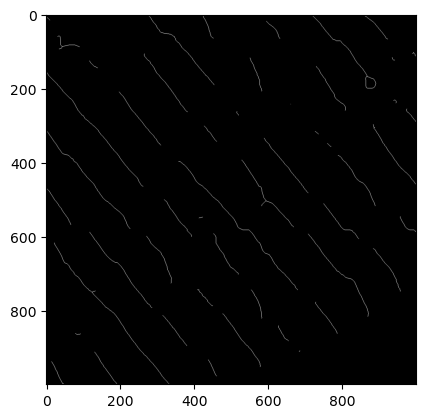

In [39]:
# Choose a region to zoom into
x_start, x_end = 3000, 4000
y_start, y_end = 3000, 4000

zoomed_skeleton_image = skeleton_uint8[y_start:y_end, x_start:x_end]

# Display the zoomed-in section
plt.imshow(zoomed_skeleton_image, cmap='gray')
plt.show()

In [65]:
pred_lines = probabilistic_hough_line(skeleton_uint8, threshold=50, line_length=50, line_gap=50)

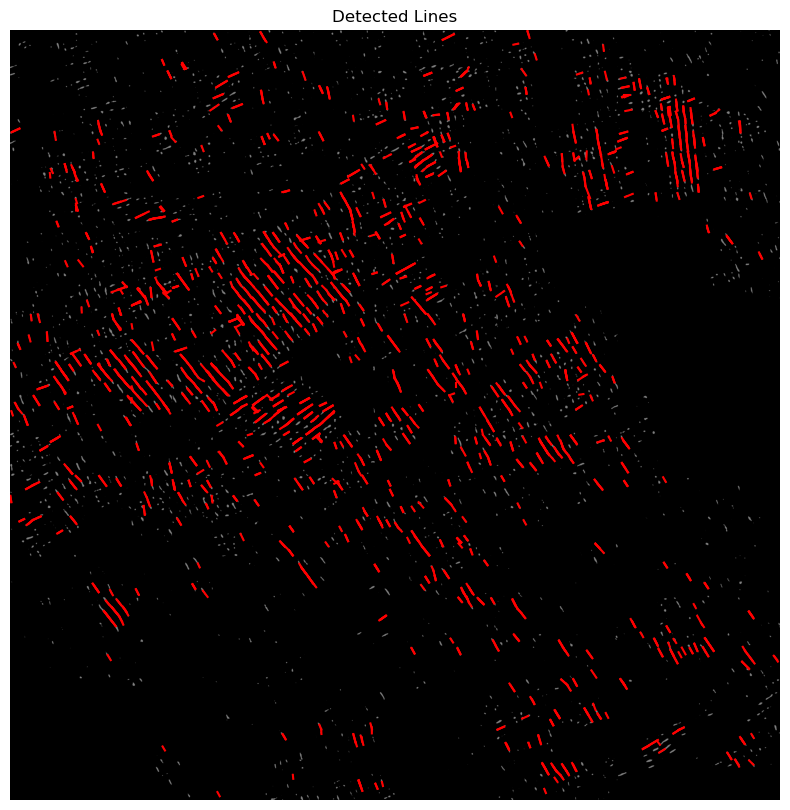

In [66]:
# Plotting the detected lines
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
plt.title('Detected Lines')

# Plot each line detected
for line in pred_lines:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]), '-r')  # '-r' means red line

# Optionally, overlay the edge-detected image to see how the lines fit
plt.imshow(edges, cmap='gray', alpha=0.5)

plt.axis('off')
plt.show()

In [59]:
len(lines)

2084

In [62]:
with rasterio.open(tif_path) as src:
    input_image = src.read(1)  # Read the first band (assuming grayscale)
    meta = src.meta  # Get the metadata for the image
    transform = src.transform  # Get the affine transform

In [63]:
line_image = np.zeros_like(input_image, dtype=np.uint8)

In [68]:
for line in pred_lines:
    (x0, y0), (x1, y1) = line
    rr, cc = skimage_line(y0, x0, y1, x1)  # Get coordinates of the line
    line_image[rr, cc] = 255  # Draw white lines

meta.update(dtype=rasterio.uint8, count=1)  # Update metadata for the output image

In [72]:
output_tif_path = os.path.join(curr_path, 'Data/final_output/output_2.tif')

with rasterio.open(output_tif_path, 'w', **meta) as dst:
    dst.write(line_image, 1)  # Write the line image to the first band

print(f"Line-detected image saved to {output_tif_path}")

Line-detected image saved to D:\Masters\OVGU\VII_Semester\Thesis\jupyter_notebooks\Data/final_output/output_2.tif


### Pre Hough Post - Experiment

In [91]:
import rasterio
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [76]:
curr_path = os.getcwd()

print(curr_path)

D:\Masters\OVGU\VII_Semester\Thesis\jupyter_notebooks


In [79]:
tif_path = os.path.join(curr_path, 'Data\Merged\merged.tif')

print(tif_path)

D:\Masters\OVGU\VII_Semester\Thesis\jupyter_notebooks\Data\Merged\merged.tif


In [80]:
with rasterio.open(tif_path) as src:
    input_image = src.read(1)  # Read the first band (assuming grayscale)
    meta = src.meta  # Get the metadata for the image
    transform = src.transform  # Get the affine transform

In [127]:
min_val = np.min(input_image)
max_val = np.max(input_image)

# Normalize to range [0, 1]
image_normalized = (input_image - min_val) / (max_val - min_val)

# Scale to range [0, 255] and convert to uint8
image_uint8 = (image_normalized * 255).astype(np.uint8)

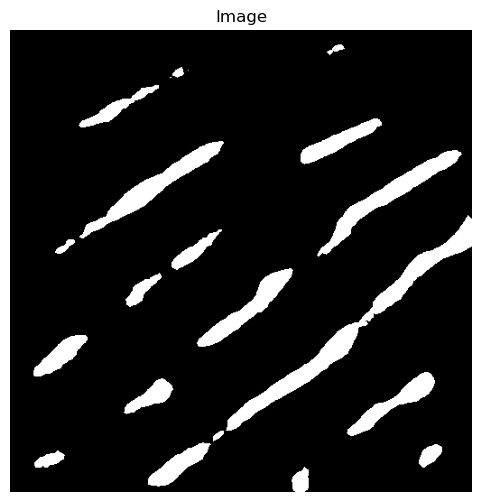

In [128]:
# Plot the eroded image
plt.figure(figsize=(6, 6))
plt.imshow(image_uint8, cmap='gray')  # Display in grayscale
plt.title('Image')
plt.axis('off')  # Hide axis
plt.show()

In [ ]:
# Choose a region to zoom into
x_start, x_end = 3000, 4000
y_start, y_end = 3000, 4000

zoomed_erode_image = eroded[y_start:y_end, x_start:x_end]

# Display the zoomed-in section
plt.imshow(zoomed_erode_image, cmap='gray')
plt.show()

In [83]:
kernel = np.ones((5, 5), np.uint8)  # Adjust size as needed
dilated = cv2.dilate(image_uint8, kernel, iterations=1)
eroded = cv2.erode(dilated, kernel, iterations=1)

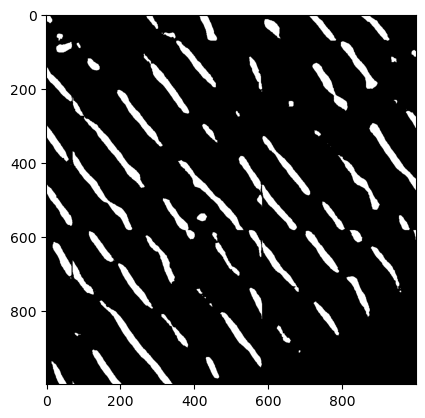

In [103]:
# Choose a region to zoom into
x_start, x_end = 3000, 4000
y_start, y_end = 3000, 4000

zoomed_image = image_uint8[y_start:y_end, x_start:x_end]

# Display the zoomed-in section
plt.imshow(zoomed_image, cmap='gray')
plt.show()

In [85]:
median_filtered = cv2.medianBlur(eroded, 5)  # Adjust kernel size if necessary

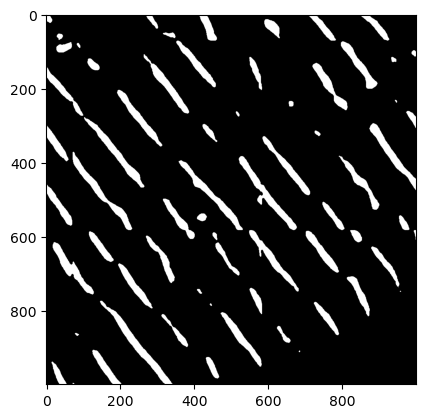

In [101]:
# Choose a region to zoom into
x_start, x_end = 3000, 4000
y_start, y_end = 3000, 4000

zoomed_median_image = median_filtered[y_start:y_end, x_start:x_end]

# Display the zoomed-in section
plt.imshow(zoomed_median_image, cmap='gray')
plt.show()

In [89]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(median_filtered, connectivity=8)
min_size = 100  # Minimum size of the components to keep
filtered = np.zeros_like(median_filtered)
for i in range(1, num_labels):  # Label 0 is the background
    if stats[i, cv2.CC_STAT_AREA] >= min_size:
        filtered[labels == i] = 255

In [90]:
edges = cv2.Canny(filtered, 50, 150)  # Adjust thresholds as needed

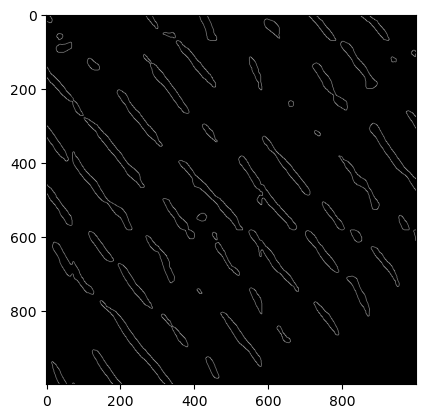

In [96]:
# Choose a region to zoom into
x_start, x_end = 3000, 4000
y_start, y_end = 3000, 4000

zoomed_edge_image = edges[y_start:y_end, x_start:x_end]

# Display the zoomed-in section
plt.imshow(zoomed_edge_image, cmap='gray')
plt.show()

In [105]:
binary_image = edges > 0

skeleton = skeletonize(binary_image)

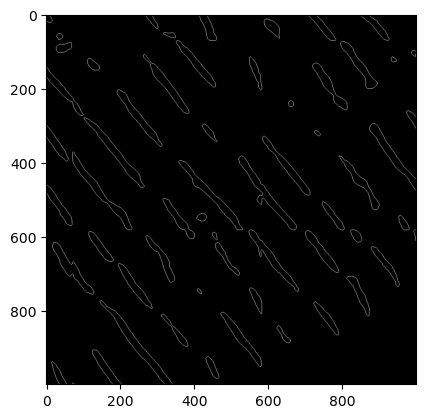

In [106]:
# Choose a region to zoom into
x_start, x_end = 3000, 4000
y_start, y_end = 3000, 4000

zoomed_skeleton_image = skeleton[y_start:y_end, x_start:x_end]

# Display the zoomed-in section
plt.imshow(zoomed_skeleton_image, cmap='gray')
plt.show()

In [97]:
from skimage.transform import probabilistic_hough_line

lines = probabilistic_hough_line(edges, threshold=10, line_length=50, line_gap=10)

In [98]:
min_length = 50  # Minimum length of lines to keep
filtered_lines = [line for line in lines if np.linalg.norm(np.array(line[0]) - np.array(line[1])) > min_length]

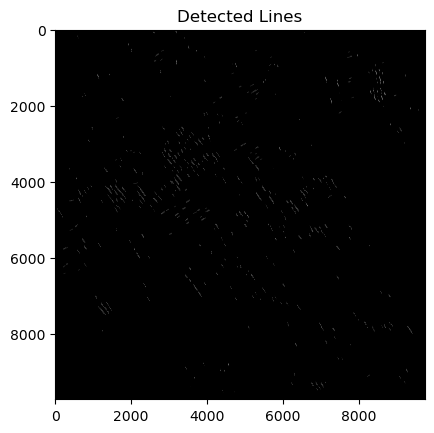

In [99]:
line_image = np.zeros_like(edges)
for line in filtered_lines:
    p0, p1 = line
    cv2.line(line_image, p0, p1, (255, 255, 255), 2)

plt.imshow(line_image, cmap='gray')
plt.title('Detected Lines')
plt.show()

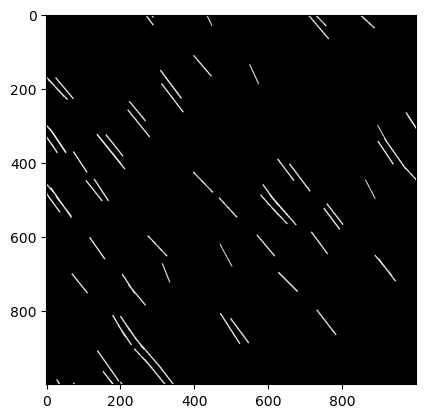

In [100]:
x_start, x_end = 3000, 4000
y_start, y_end = 3000, 4000

zoomed_line_image = line_image[y_start:y_end, x_start:x_end]

# Display the zoomed-in section
plt.imshow(zoomed_line_image, cmap='gray')
plt.show()

### Hough - Small Tiles

In [107]:
import rasterio
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize

In [51]:
curr_path = os.getcwd()

print(curr_path)

D:\Masters\OVGU\VII_Semester\Thesis\jupyter_notebooks


In [52]:
tile_path = os.path.join(curr_path, 'Data\outputs_tile_2\output_3584_4608.tif')

print(tile_path)

D:\Masters\OVGU\VII_Semester\Thesis\jupyter_notebooks\Data\outputs_tile_2\output_3584_4608.tif


In [53]:
with rasterio.open(tile_path) as src:
    input_image = src.read(1)  # Read the first band (assuming grayscale)
    meta = src.meta  # Get the metadata for the image
    transform = src.transform  # Get the affine transform

In [54]:
min_val = np.min(input_image)
max_val = np.max(input_image)

# Normalize to range [0, 1]
tile_normalized = (input_image - min_val) / (max_val - min_val)

# Scale to range [0, 255] and convert to uint8
tile_uint8 = (tile_normalized * 255).astype(np.uint8)

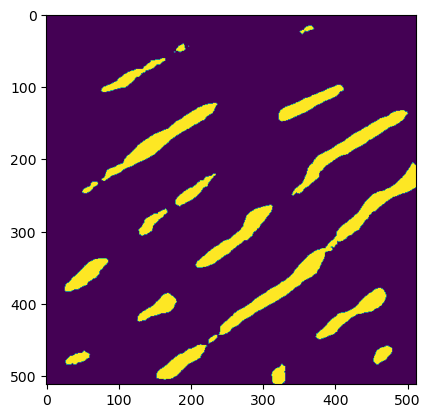

In [55]:
plt.imshow(tile_uint8)

In [133]:
tile_lines = cv2.HoughLinesP(tile_uint8, 1, np.pi / 180, threshold=50, minLineLength=10, maxLineGap=50)

In [134]:
print(len(tile_lines))

183


In [135]:
# Create a blank image (same dimensions as tile_uint8) to draw lines on
blank_image = np.zeros((512, 512), dtype=np.uint8)

In [136]:
if tile_lines is not None:
    for line in tile_lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(blank_image, (x1, y1), (x2, y2), 255, 2)  # White lines

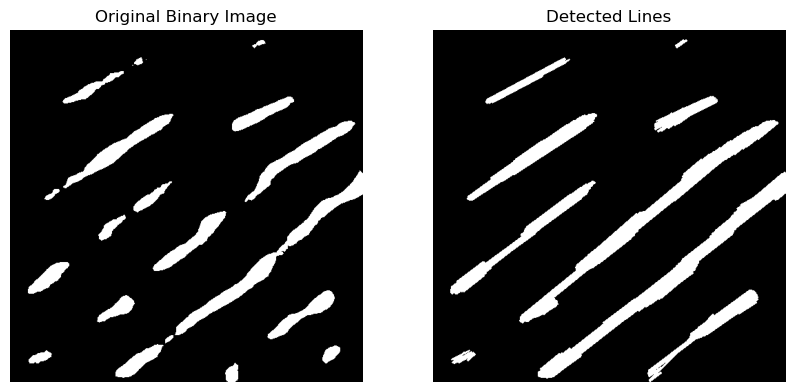

In [137]:
# Display the original binary image and the detected lines
plt.figure(figsize=(10, 5))

# Plot the original binary image
plt.subplot(1, 2, 1)
plt.imshow(tile_uint8, cmap='gray')
plt.title('Original Binary Image')
plt.axis('off')

# Plot the detected lines
plt.subplot(1, 2, 2)
plt.imshow(blank_image, cmap='gray')
plt.title('Detected Lines')
plt.axis('off')

# Show the plots
plt.show()

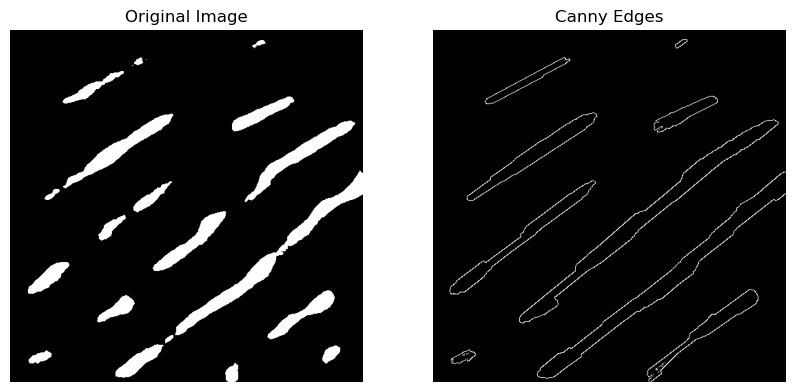

In [138]:
tile_edges = cv2.Canny(blank_image, threshold1=100, threshold2=200)

plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(tile_uint8, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Edge-detected Image
plt.subplot(1, 2, 2)
plt.imshow(tile_edges, cmap='gray')
plt.title('Canny Edges')
plt.axis('off')

plt.show()

In [139]:
# Find contours in the edge-detected image
tile_contours, _ = cv2.findContours(tile_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours onto a new image
tile_lines = np.zeros_like(tile_uint8)
contour_image = cv2.drawContours(tile_lines, tile_contours, -1, (255, 255, 255), thickness=5)

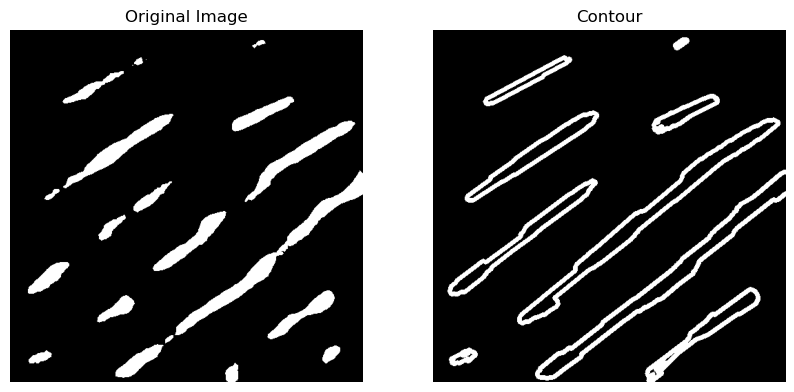

In [140]:
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(tile_uint8, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Edge-detected Image
plt.subplot(1, 2, 2)
plt.imshow(contour_image, cmap='gray')
plt.title('Contour')
plt.axis('off')

plt.show()

In [141]:
# Define a kernel
kernel = np.ones((15,15), np.uint8)

# Apply dilation
dilated_edges = cv2.dilate(contour_image, kernel, iterations=1)

binary_image = dilated_edges > 0

skeleton = skeletonize(binary_image)

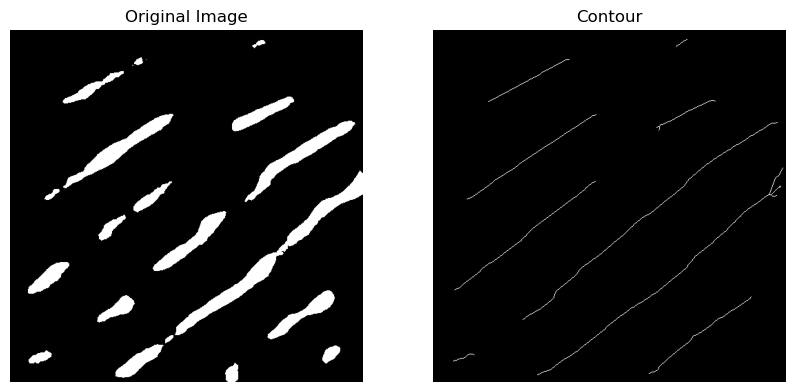

In [142]:
skeleton_uint8 = (skeleton * 255).astype(np.uint8)

plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(tile_uint8, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Edge-detected Image
plt.subplot(1, 2, 2)
plt.imshow(skeleton_uint8, cmap='gray')
plt.title('Contour')
plt.axis('off')

plt.show()

In [159]:
refined_lines = cv2.HoughLinesP(skeleton_uint8, 1, np.pi / 180, threshold=40, minLineLength=10, maxLineGap=50)

In [160]:
len(refined_lines)

16

In [161]:
refined_blank = np.zeros((512, 512), dtype=np.uint8)

In [162]:
if refined_lines is not None:
    for line in refined_lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(refined_blank, (x1, y1), (x2, y2), 255, 2)  # White lines

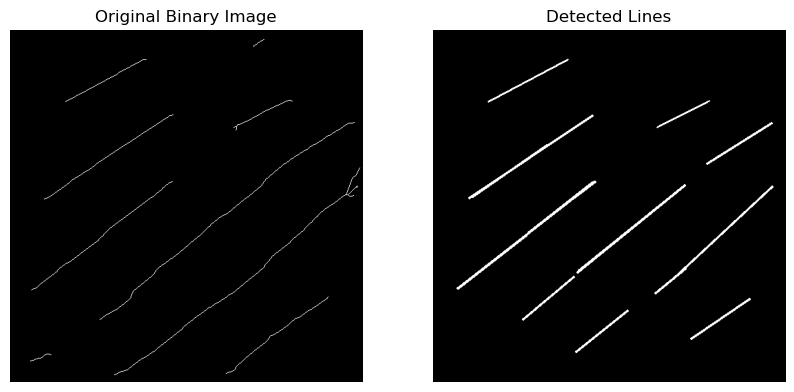

In [163]:
# Display the original binary image and the detected lines
plt.figure(figsize=(10, 5))

# Plot the original binary image
plt.subplot(1, 2, 1)
plt.imshow(skeleton_uint8, cmap='gray')
plt.title('Original Binary Image')
plt.axis('off')

# Plot the detected lines
plt.subplot(1, 2, 2)
plt.imshow(refined_blank, cmap='gray')
plt.title('Detected Lines')
plt.axis('off')

# Show the plots
plt.show()